In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
sys.path.insert(1, '/host/cassio/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')

import plotting
import utils

In [3]:
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe'
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'

sub = glob.glob(hippunfold_dir + '/*')
for i in range(len(sub)): sub[i] = sub[i].split('/')[-1]
ses = 'ses-01'
hemi = ['L','R']
label = ['hipp','dentate'] 
ind = [range(7262), range(7262,7262+1788)]

In [3]:
features = ['model-DTI_map-FA', 'model-DTI_map-ADC']
for f in range(len(features)):
    for s in range(len(sub)):
        tfrm = glob.glob(f'{micapipe_dir}/{sub[s]}/{ses}/xfm/{sub[s]}_{ses}_space-dwi_from-dwi_to-nativepro_mode-image_desc-*0GenericAffine.mat')
        cmd1 = f'antsApplyTransforms -d 3 -o tmp.nii.gz '\
            f'-i {micapipe_dir}/{sub[s]}/{ses}/dwi/{sub[s]}_{ses}_space-dwi_{features[f]}.nii.gz '\
            f'-r {micapipe_dir}/{sub[s]}/{ses}/dwi/{sub[s]}_{ses}_space-dwi_{features[f]}.nii.gz '\
            f'-t {tfrm}'
        !{cmd1}
        for h in range(len(hemi)):
            for l in range(len(label)):
                cmd2 = f'wb_command -volume-to-surface-mapping '\
                    f'tmp.nii.gz '\
                    f'{hippunfold_dir}/{sub[s]}/{ses}/surf/{sub[s]}_{ses}_hemi-{hemi[h]}_space-T1w_den-0p5mm_label-{label[l]}_midthickness.surf.gii '\
                    f'{hippunfold_dir}/{sub[s]}/{ses}/surf/{sub[s]}_{ses}_hemi-{hemi[h]}_space-T1w_den-0p5mm_label-{label[l]}_{features[f]}.shape.gii '\
                    f'-trilinear'
                !{cmd2}
!rm tmp.nii.gz

 file /data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC004/ses-01/dwi/sub-HC004_ses-01_space-dwi_model-DTI_map-FA.nii.gz does not exist . 
 file /data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC004/ses-01/dwi/sub-HC004_ses-01_space-dwi_model-DTI_map-FA.nii.gz does not exist . 
Transform file does not exist: 
 file /data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC004/ses-01/dwi/sub-HC004_ses-01_space-dwi_model-DTI_map-ADC.nii.gz does not exist . 
 file /data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC004/ses-01/dwi/sub-HC004_ses-01_space-dwi_model-DTI_map-ADC.nii.gz does not exist . 
Transform file does not exist: 


In [14]:
# qT1 not processed by micapipe
for s in range(len(sub)):
    cmd1 = f'antsApplyTransforms -d 3 -o tmp.nii.gz '\
        f'-i {micapipe_dir}/{sub[s]}/{ses}/anat/qt1/{sub[s]}_{ses}_space-qt1_desc-qt1_brain.nii.gz '\
        f'-r {micapipe_dir}/{sub[s]}/{ses}/anat/qt1/{sub[s]}_{ses}_space-qt1_desc-qt1_brain.nii.gz '\
        f'-t [{micapipe_dir}/{sub[s]}/{ses}/xfm/{sub[s]}_{ses}_from-nativepro_t1w_to_qt1_0GenericAffine.txt,1] '
    !{cmd1}
    for h in range(len(hemi)):
        for l in range(len(label)):
            cmd2 = f'wb_command -volume-to-surface-mapping '\
                f'tmp.nii.gz '\
                f'{hippunfold_dir}/{sub[s]}/{ses}/surf/{sub[s]}_{ses}_hemi-{hemi[h]}_space-T1w_den-0p5mm_label-{label[l]}_midthickness.surf.gii '\
                f'{hippunfold_dir}/{sub[s]}/{ses}/surf/{sub[s]}_{ses}_hemi-{hemi[h]}_space-T1w_den-0p5mm_label-{label[l]}_qT1.shape.gii '\
                f'-trilinear'
            !{cmd2}
!rm tmp.nii.gz

In [15]:
features = ['thickness', 'gyrification', 'curvature', 'model-DTI_map-FA', 'model-DTI_map-ADC', 'qT1']
hipp_dat = np.zeros([7262+1788,2,len(sub),len(features)])*np.nan

for f in range(len(features)):
    for s in range(len(sub)):
        for h in range(len(hemi)):
            c = np.array([])
            for l in range(len(label)):
                try:
                    d = nib.load(f'{hippunfold_dir}/{sub[s]}/{ses}/surf/'\
                                 f'{sub[s]}_{ses}_hemi-{hemi[h]}_space-T1w'\
                                 f'_den-0p5mm_label-{label[l]}_{features[f]}.shape.gii')
                    hipp_dat[ind[l],h,s,f] = d.darrays[0].data
                except:
                    hipp_dat[ind[l],h,s,f] = 0

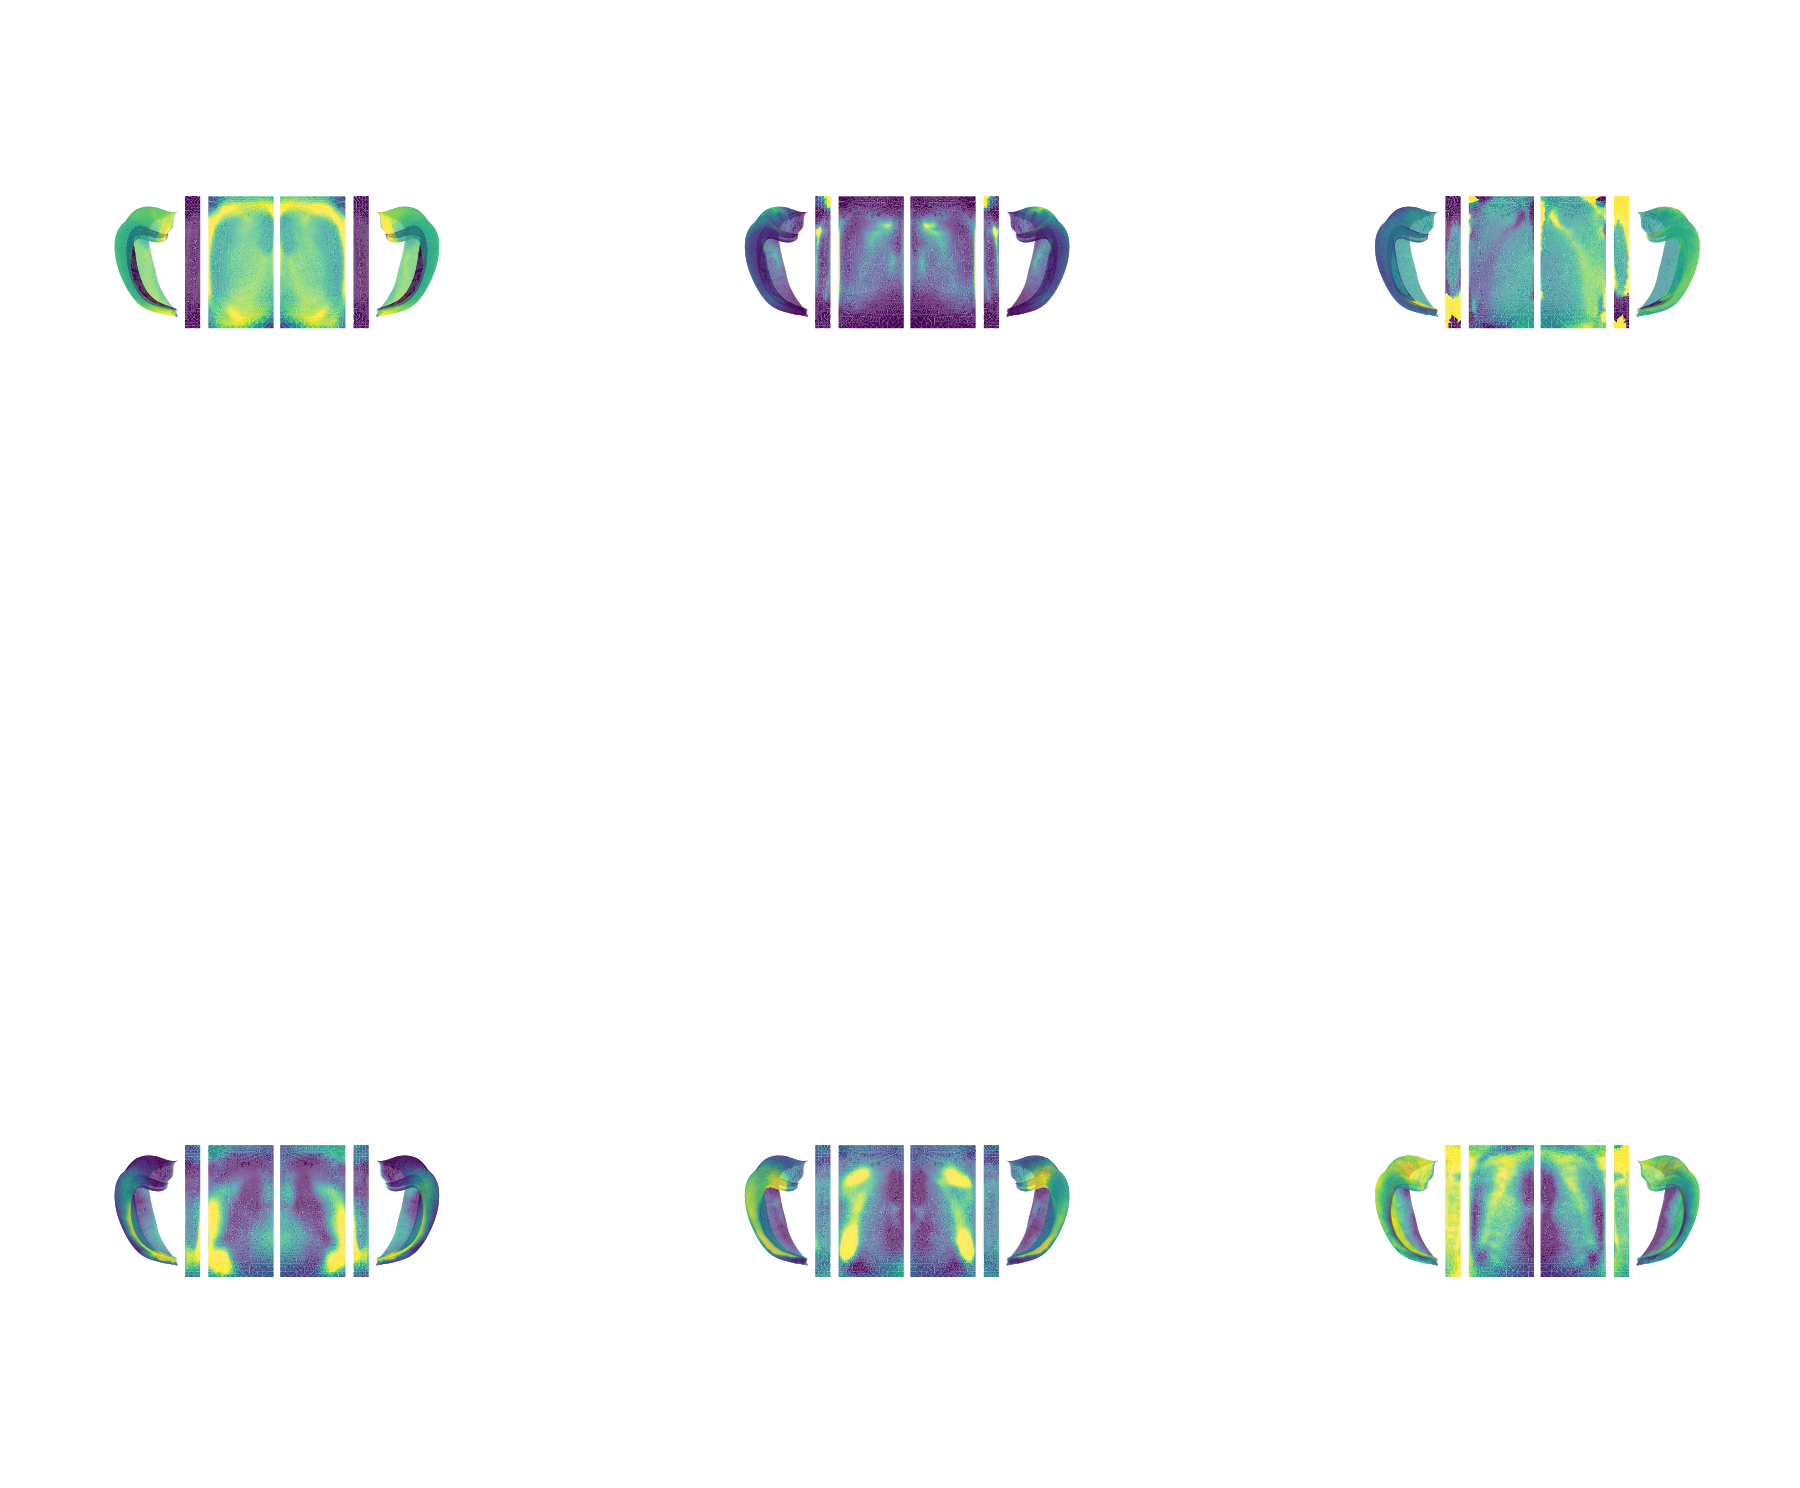

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(32,32), subplot_kw={'projection': "3d"})
for f in range(len(features)):
    plotting.surfplot_canonical_foldunfold(ax[np.unravel_index(f,ax.shape)], 
           np.nanmean(hipp_dat[:,:,:,f],axis=2).flatten(order='F'), den='0p5mm', cwindow=True)